# ML notebook 1: Unsupervised 

Here I implement unsupervised learning methods to visualize and classify data simulated under different demographic scenarios. We'll apply first dimensionality reduction methods (PCA and tSNE) to extract features from the data and visualize it, and then we apply classification methods (Kmeans and Decision Trees to both the raw and transformed data). 


In [655]:
import h5py
import simcat
import toytree
import toyplot
import toyplot.svg
import numpy as np
import pandas as pd

# machine learning methods
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import tree

### Load in databases 
First we can load some metadata from the databases, such as the tree that was used for simulations. 

In [637]:
#with h5py.File("../databases/tr5-t5-r2-s10000.counts.h5") as io5:
#with h5py.File("../databases/tr8-t5-r2-s10000.counts.h5") as io5:
with h5py.File("../databases/tr6-t10-r20-s20000.counts.h5") as io5:
    newick = io5.attrs['tree']
    ttree = toytree.tree(newick)
    ttree.draw(tree_style='c')

<svg class="toyplot-canvas-Canvas" height="275.0px" id="td8dbd135f88d4a76908761a595ba90a9" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 350.0 275.0" width="350.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> idx: 0
name: 0
dist: 0.7500
support: 100
height: 0.0000 0 idx: 1
name: 1
dist: 0.7500
support: 100
height: 0.0000 1 idx: 2
name: 2
dist: 1.5000
support: 100
height: 0.0000 2 idx: 3
name: 3
dist: 2.2500
support: 100
height: 0.0000 3 idx: 4
name: 4
dist: 1.5000
support: 100
height: 0.0000 4 idx: 5
name: 5
dist: 1.5000
support: 100
height: 0.0000 5 idx: 6
name: 6
dist: 0.7500
support: 1
height: 0.7500 6 idx: 7
name: 7
dist: 0.7500
support: 1
height: 1.5000 7 idx: 8
name: 8
dist: 0.7500
support: 1
height: 2.2500 8 idx: 9
name: 9
dist: 1.5000
support: 1
height: 1.5000 9 idx: 10
name: 10
dist: 0.0000
support: 100
height: 3.0000 10 0.00 1.50 3.00

### Load the features (SNP counts data)
We load in the full counts matrix and then flatten it into vectors of SNP count patterns. 

In [638]:
#with h5py.File("../databases/tr5-t5-r2-s10000.counts.h5") as io5:
#with h5py.File("../databases/tr8-t5-r2-s10000.counts.h5") as io5:
with h5py.File("../databases/tr6-t10-r20-s20000.counts.h5") as io5:
    counts = io5["counts"][:]
    X = np.array([i.flatten() for i in io5['counts']])
    print(counts.shape)
    print(X.shape)

(9200, 15, 16, 16)
(9200, 3840)


### Load the labels (demographic scenarios)
We are not actually using this data to fit models in this notebook (they are unsupervised models) but we will use these data to validate and visualize the results with respect to known labels for the data. 

In [642]:
# load in the features database
#with h5py.File("../databases/tr5-t5-r2-s10000.labels.h5") as io5:
#with h5py.File("../databases/tr8-t5-r2-s10000.labels.h5") as io5:
with h5py.File("../databases/tr6-t10-r20-s20000.labels.h5") as io5:
    df = pd.DataFrame({
        "theta": io5["thetas"][:],
        "asource": io5["admix_sources"][:].flatten(),
        "atarget": io5["admix_targets"][:].flatten(),
        "atimes": io5["admix_times"][:].flatten(),
        "aprops": io5["admix_props"][:].flatten(),
    })
    
# make a category for each (source, target) pair
df["label"] = df.asource.astype(str).str.cat(df.atarget.astype(str), sep=",")

# add a column to dataframe for sisters migration or not
df["sisters"] = 0
for idx in df.index:
    sis1 = df.asource[idx]
    sis2 = df.atarget[idx]
    node1 = ttree.treenode.search_nodes(idx=sis1)[0]
    node2 = ttree.treenode.search_nodes(idx=sis2)[0]
    if node1 in node2.get_sisters():
        df.loc[idx, "sisters"] = 1

# unordered labels (no directionality)
df["ulabel"] = ["{},{}".format(*i) for i in df.label.apply(lambda x: sorted([int(i) for i in x.split(",")]))]

# show random samples
df.sample(10)

theta  asource  atarget  atimes    aprops label  sisters ulabel
2274  1.343685        4        3   0.750  0.088773   4,3        0    3,4
3955  1.431694        3        7   1.875  0.083941   3,7        1    3,7
4078  1.090514        3        2   0.750  0.140379   3,2        0    2,3
1006  1.343729        5        3   0.750  0.255690   5,3        0    3,5
3707  0.393136        3        4   0.750  0.316284   3,4        0    3,4
3534  0.393030        3        5   0.750  0.384804   3,5        0    3,5
1920  0.758703        5        0   0.375  0.250922   5,0        0    0,5
2814  0.337237        4        1   0.375  0.257774   4,1        0    1,4
8431  1.687195        0        4   0.375  0.265927   0,4        0    0,4
8551  1.445882        0        4   0.375  0.359962   0,4        0    0,4

### Split data for training and testing

In [644]:
Y = df.ulabel
Ytrain = Y[::2]
Ytest = Y[1::2]
Xtrain = X[::2]
Xtest = X[1::2]

Xtest.shape, Ytest.shape, Xtrain.shape, Ytrain.shape

((4600, 3840), (4600,), (4600, 3840), (4600,))

### PCA: principle components analysis

Linear dimensionality reduction using SVD: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA

In [483]:
# define a model
pca = PCA().fit(X)

# fit and tranform
Xf = pca.transform(X)

### Plot components


Colored by whether migration is between sister species or not, and size is  the proportion of migrants. We can see clearly that the scenarios with migration between sister species are hardest to distinguish and cluster at the center. Scenarios with more migration are furthest from the center, meaning they are easiest to distinguish. 

In [484]:
canvas, axes, mark = toyplot.scatterplot(
    X[:, 0], X[:, 1],
    width=400, height=350,
    xlabel="PC1 ({:.1f}% explained)".format(
        100 * pca.explained_variance_ratio_[0]),
    ylabel="PC2 ({:.1f}% explained)".format(
        100 * pca.explained_variance_ratio_[1]),
    size=16 * df.aprops,
    opacity=0.5,
    color=[
        toyplot.color.Palette()[0] if i==1 else 
        toyplot.color.Palette()[1] for i in df.sisters
    ],
);

<svg class="toyplot-canvas-Canvas" height="350.0px" id="t6e26ff758098410bbbdb23a184634384" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 400.0 350.0" width="400.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> <g class="toyplot-Datum" style="fill:rgb(98.8%,55.3%,38.4%);fill-opacity

Many other patterns are hidden in these decomposed vectors. Below we can see that components 0 and 8 together cluster data near the center for scenarios where the introgressive donor is either taxon 4 or 5, demonstrating some of the power in these data for polarizing introgression.  

In [485]:
canvas, axes, mark = toyplot.scatterplot(
    X[:, 0], X[:, 8],
    width=400, height=350,
    xlabel="PC1 ({:.1f}% explained)".format(
        100 * pca.explained_variance_ratio_[0]),
    ylabel="PC9 ({:.1f}% explained)".format(
        100 * pca.explained_variance_ratio_[8]),
    size=16 * df.aprops,
    opacity=0.5,
    color=[
        toyplot.color.Palette()[2] if i in (4, 5) else 
        toyplot.color.Palette()[1] for i in df.asource
    ],
);

<svg class="toyplot-canvas-Canvas" height="350.0px" id="tede4463343ac46d1a38483ea27f74d8c" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 400.0 350.0" width="400.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> <g class="toyplot-Datum" style="fill:rgb(98.8%,55.3%,38.4%);fill-opacity:1.0;opacity:0.5;stroke:rgb(98.8%,55.3%,38.4%);stroke-opacity:1.0" transform="translate(228.6082474226804, 2

### tSNE: t-distributed Stochastic Neighbor Embedding.

https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
t-SNE [1] is a tool to visualize high-dimensional data. It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data. t-SNE has a cost function that is not convex, i.e. with different initializations we can get different results.

In [645]:
X_embedded2 = TSNE(n_components=2, init='pca', perplexity=70, random_state=0).fit_transform(X)

In [646]:
#X_embedded = TSNE(n_components=2, init='pca', perplexity=50, random_state=0).fit_transform(X)

In [653]:
colors = [0] * df.shape[0]
for idx in df.index:
    if df.sisters[idx]:
        colors[idx] = 1
    if df.asource[idx] == 5:
        colors[idx] = 2
    if df.asource[idx] == 4:
        colors[idx] = 3

The cluster in the plot below match to embedded features in the data that were extracted by t-SNE. By overlaying size and color on each data point we can see that these features align well with the known labels of the data. Below, orange colors points where migration occurred between sister lineages, and purple are points where introgression originated from taxon 5. 

In [654]:
c, a, m = toyplot.scatterplot(
    X_embedded2[:, 0],
    X_embedded2[:, 1],
    width=350, height=350,
    color= [toyplot.color.Palette()[i] for i in colors],
    title=df.label,
    size=df.aprops * 16,
    opacity=0.5,
);

toyplot.svg.render(c, "../figures/tr6-t10-r20-s20000-tSNE.svg")
c

<svg class="toyplot-canvas-Canvas" height="350.0px" id="t8c6972aa37844654b9504e3d103ad860" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 350.0 350.0" width="350.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 <g class="toyplot-Datum" style="fill:rgb(98.8%,55.3%,38.4%);fill-opacity:1.0;opacity:0.5;stroke:rgb(98.8%,55.3%,38.4%);stroke-opacity:1.0" transform="translate(133.8475537091266, 191.

In [450]:
toyplot.scatterplot(
    X_embedded2[:, 0],
    X_embedded2[:, 1],
    width=350, height=350,
    color= [toyplot.color.Palette()[i] for i in colors],
    title=df.label,
    size=df.aprops * 16,
    opacity=0.5,
);

<svg class="toyplot-canvas-Canvas" height="350.0px" id="te65c282843c045c8b4dce02a1565723d" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 350.0 350.0" width="350.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> 13,12 13,12 13,12 13,12 13,12 13,12 13,12 13,12 13,12 13,12 12,13 12,13 12,13 12,13 12,13 12,13 12,13 12,13 12,13 12,13 7,11 7,11 7,11 7,11 7,11 7,11 7,11 7,11 7,11 7,11 7,3 7,3 7,3 7,3 7,3 7,3 7,3 7,3 7,3 7,3 7,10 7,10 7,10 7,10 7,10 7,10 7,10 7,10 7,10 7,10 7,6 7,6 7,6 7,6 7,6 7,6 7,6 7,6 7,6 7,6 7,9 7,9 7,9 7,9 7,9 7,9 7,9 7,9 7,9 7,9 7,2 7,2 7,2 7,2 7,2 7,2 7,2 7,2 7,2 7,2 7,8 7,8 7,8 7,8 7,8 7,8 7,8 7,8 7,8 7,8 7,5 7,5 7,5 7,5 7,5 7,5 7,5 7,5 7,5 7,5 7,4 7,4 7,4 7,4 7,4 7,4 7,4 7,4 7,4 7,4 7,1 7,1 7,1 7,1 7,1 7,1 7,1 7,1 7,1 7,1 7,0 7,0 7,0 7,0 7,0 7,0 7,0 7,0 7,0 7,0 11,7 11,7 11,7 11,7 11,7 11,7 11,7 11,7 11,7 11,7 11,3 11,3 11,3 11,3 11,3 11,3 11,3 11,3 11,3 11,3 11,10 11,10 11,10 11,10 11,10 11,10 11,10 11,10 11,10 11,10 3,7 3,7 3,7 3,7 3,7 3,7 3,7 3,7 3,7 3,7 3,11 3,11 3,11 3,11 3,11 3,11 3,11 3,11 3,11 3,11 3,10 3,10 3,10 3,10 3,10 3,10 3,10 3,10 3,10 3,10 3,6 3,6 3,6 3,6 3,6 3,6 3,6 3,6 3,6 3,6 3,9 3,9 3,9 3,9 3,9 3,9 3,9 3,9 3,9 3,9 3,2 3,2 3,2 3,2 3,2 3,2 3,2 3,2 3,2 3,2 3,8 3,8 3,8 3,8 3,8 3,8 3,8 3,8 3,8 3,8 3,5 3,5 3,5 3,5 3,5 3,5 3,5 3,5 3,5 3,5 3,4 3,4 3,4 3,4 3,4 3,4 3,4 3,4 3,4 3,4 3,1 3,1 3,1 3,1 3,1 3,1 3,1 3,1 3,1 3,1 3,0 3,0 3,0 3,0 3,0 3,0 3,0 3,0 3,0 3,0 10,7 10,7 10,7 10,7 10,7 10,7 10,7 10,7 10,7 10,7 10,11 10,11 10,11 10,11 10,11 10,11 10,11 10,11 10,11 10,11 10,3 10,3 10,3 10,3 10,3 10,3 10,3 10,3 10,3 10,3 6,7 6,7 6,7 6,7 6,7 6,7 6,7 6,7 6,7 6,7 6,3 6,3 6,3 6,3 6,3 6,3 6,3 6,3 6,3 6,3 6,9 6,9 6,9 6,9 6,9 6,9 6,9 6,9 6,9 6,9 6,2 6,2 6,2 6,2 6,2 6,2 6,2 6,2 6,2 6,2 6,8 6,8 6,8 6,8 6,8 6,8 6,8 6,8 6,8 6,8 6,5 6,5 6,5 6,5 6,5 6,5 6,5 6,5 6,5 6,5 6,4 6,4 6,4 6,4 6,4 6,4 6,4 6,4 6,4 6,4 6,1 6,1 6,1 6,1 6,1 6,1 6,1 6,1 6,1 6,1 6,0 6,0 6,0 6,0 6,0 6,0 6,0 6,0 6,0 6,0 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,7 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,3 9,6 9,6 9,6 9,6 9,6 9,6 9,6 9,6 9,6 9,6 9,2 9,2 9,2 9,2 9,2 9,2 9,2 9,2 9,2 9,2 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 9,8 2,7 2,7 2,7 2,7 2,7 2,7 2,7 2,7 2,7 2,7 2,3 2,3 2,3 2,3 2,3 2,3 2,3 2,3 2,3 2,3 2,6 2,6 2,6 2,6 2,6 2,6 2,6 2,6 2,6 2,6 2,9 2,9 2,9 2,9 2,9 2,9 2,9 2,9 2,9 2,9 2,8 2,8 2,8 2,8 2,8 2,8 2,8 2,8 2,8 2,8 2,5 2,5 2,5 2,5 2,5 2,5 2,5 2,5 2,5 2,5 2,4 2,4 2,4 2,4 2,4 2,4 2,4 2,4 2,4 2,4 2,1 2,1 2,1 2,1 2,1 2,1 2,1 2,1 2,1 2,1 2,0 2,0 2,0 2,0 2,0 2,0 2,0 2,0 2,0 2,0 8,7 8,7 8,7 8,7 8,7 8,7 8,7 8,7 8,7 8,7 8,3 8,3 8,3 8,3 8,3 8,3 8,3 8,3 8,3 8,3 8,6 8,6 8,6 8,6 8,6 8,6 8,6 8,6 8,6 8,6 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,9 8,2 8,2 8,2 8,2 8,2 8,2 8,2 8,2 8,2 8,2 5,7 5,7 5,7 5,7 5,7 5,7 5,7 5,7 5,7 5,7 5,3 5,3 5,3 5,3 5,3 5,3 5,3 5,3 5,3 5,3 5,6 5,6 5,6 5,6 5,6 5,6 5,6 5,6 5,6 5,6 5,2 5,2 5,2 5,2 5,2 5,2 5,2 5,2 5,2 5,2 5,4 5,4 5,4 5,4 5,4 5,4 5,4 5,4 5,4 5,4 5,1 5,1 5,1 5,1 5,1 5,1 5,1 5,1 5,1 5,1 5,0 5,0 5,0 5,0 5,0 5,0 5,0 5,0 5,0 5,0 4,7 4,7 4,7 4,7 4,7 4,7 4,7 4,7 4,7 4,7 4,3 4,3 4,3 4,3 4,3 4,3 4,3 4,3 4,3 4,3 4,6 4,6 4,6 4,6 4,6 4,6 4,6 4,6 4,6 4,6 4,2 4,2 4,2 4,2 4,2 4,2 4,2 4,2 4,2 4,2 4,5 4,5 4,5 4,5 4,5 4,5 4,5 4,5 4,5 4,5 4,1 4,1 4,1 4,1 4,1 4,1 4,1 4,1 4,1 4,1 4,0 4,0 4,0 4,0 4,0 4,0 4,0 4,0 4,0 4,0 1,7 1,7 1,7 1,7 1,7 1,7 1,7 1,7 1,7 1,7 1,3 1,3 1,3 1,3 1,3 1,3 1,3 1,3 1,3 1,3 1,6 1,6 1,6 1,6 1,6 1,6 1,6 1,6 1,6 1,6 1,2 1,2 1,2 1,2 1,2 1,2 1,2 1,2 1,2 1,2 1,5 1,5 1,5 1,5 1,5 1,5 1,5 1,5 1,5 <circle r="2.704730666

### Decision Trees
This seems to work very well, and is really simple. The logic can also be extracted from the model in the end, which can be nice for trying to find and interpret invariants. 

In [652]:
Xtrain.shape

(4600, 3840)

In [571]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(Xtrain, Ytrain)
clf.score(Xtest, Ytest)

0.386046511627907

In [567]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_embedded2[1::2, :], Ytrain)
#clf.score(, Ytest)

In [650]:
from sklearn.ensemble import ExtraTreesClassifier

forest = ExtraTreesClassifier(
    n_estimators=1000,
    #max_features=256,
    n_jobs=1,
    random_state=0,
)
forest.fit(Xtrain, Ytrain)
Yforest = forest.predict(Xtest)
forest.score(Xtest, Ytest)



0.9552173913043478

In [620]:
from sklearn.ensemble import ExtraTreesClassifier

forest = ExtraTreesClassifier(
    n_estimators=1000,
    max_features=256,
    n_jobs=1,
    random_state=0,
)
forest.fit(Xtrain, Ytrain)
Yforest = forest.predict(Xtest)
forest.score(Xtest, Ytest)

0.7627906976744186

In [636]:
Ytest


1      12,13
3      12,13
5      12,13
7      12,13
9      12,13
11     12,13
13     12,13
15     12,13
17     12,13
19     12,13
21      7,11
23      7,11
25      7,11
27      7,11
29      7,11
31       3,7
33       3,7
35       3,7
37       3,7
39       3,7
41      7,10
43      7,10
45      7,10
47      7,10
49      7,10
51       6,7
53       6,7
55       6,7
57       6,7
59       6,7
       ...  
801      0,3
803      0,3
805      0,3
807      0,3
809      0,3
811      0,6
813      0,6
815      0,6
817      0,6
819      0,6
821      0,2
823      0,2
825      0,2
827      0,2
829      0,2
831      0,5
833      0,5
835      0,5
837      0,5
839      0,5
841      0,4
843      0,4
845      0,4
847      0,4
849      0,4
851      0,1
853      0,1
855      0,1
857      0,1
859      0,1
Name: ulabel, Length: 430, dtype: object

In [631]:
X_embedded2[::2, :].shape

(430, 2)

In [626]:
xx = X_embedded2[::2, :].reshape(-1, 1)
xx.shape

(860, 1)

In [635]:
from sklearn.ensemble import ExtraTreesClassifier

forest = ExtraTreesClassifier(
    n_estimators=1000,
    max_features=2,
    n_jobs=1,
    random_state=0,
)

forest.fit(X_embedded2[::2, :], Ytrain)
Yforest = forest.predict(X_embedded2[1::2])
forest.score(X_embedded2[1::2], Ytest)

0.4046511627906977

In [583]:
forest.predict_proba(Xtest)[20, :]

array([0.007, 0.004, 0.003, 0.002, 0.001, 0.002, 0.128, 0.005, 0.003,
       0.005, 0.009, 0.   , 0.085, 0.021, 0.027, 0.007, 0.003, 0.003,
       0.001, 0.158, 0.006, 0.004, 0.005, 0.037, 0.013, 0.021, 0.02 ,
       0.048, 0.002, 0.013, 0.005, 0.007, 0.001, 0.007, 0.002, 0.   ,
       0.006, 0.011, 0.136, 0.003, 0.168, 0.   , 0.011])

In [574]:
confused = confusion_matrix(Ytest, Yforest)
toyplot.matrix(confused, width=600, height=600, margin=0);

<svg class="toyplot-canvas-Canvas" height="600.0px" id="t921ed9f8c2bf4d6d8216bc216041d71c" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 600.0 600.0" width="600.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 0 4.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 1.000000 0.000000 0.000000 0.000000 0.000000 0.000000 1.000000 0.000000 1.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 2.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 1.000000 0.000000 0.000000 0.000000 1 0.000000 7.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 2.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 1.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 2 0.000000 0.000000 8.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 2.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 3 0.000000 0.000000 0.000000 10.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 4 0.000000 0.000000 0.000000 0.000000 8.000000 0.000000 0.000000 0.000000 0.000000 0.000000 1.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 1.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 5 0.000000 0.000000 0.000000 0.000000 0.000000 10.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 6 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 10.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 7 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 10.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 8 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 7.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 1.000000 0.000000 

In [530]:
from sklearn.metrics import confusion_matrix

Ypreds = clf.predict(Xtest)
confused = confusion_matrix(Ytest, Ypreds)
toyplot.matrix(confused, width=600, height=600, margin=0);

<svg class="toyplot-canvas-Canvas" height="600.0px" id="te2b3658d6bbc4f1fa427c2ee2a5b1e55" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 600.0 600.0" width="600.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 0 1.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 1.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 1.000000 0.000000 3.000000 0.000000 0.000000 0.000000 0.000000 0.000000 1.000000 0.000000 0.000000 2.000000 1.000000 0.000000 0.000000 1 0.000000 3.000000 0.000000 0.000000 0.000000 0.000000 0.000000 1.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 1.000000 0.000000 0.000000 0.000000 0.000000 0.000000 3.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 1.000000 0.000000 0.000000 1.000000 0.000000 0.000000 0.000000 0.000000 0.000000 2 0.000000 0.000000 6.000000 0.000000 0.000000 0.000000 0.000000 0.000000 1.000000 0.000000 1.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 2.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 3 0.000000 0.000000 0.000000 7.000000 2.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 1.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 4 0.000000 0.000000 0.000000 1.000000 7.000000 0.000000 0.000000 0.000000 0.000000 0.000000 1.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 1.000000 0.000000 0.000000 0.000000 0.000000 0.000000 5 0.000000 0.000000 0.000000 0.000000 0.000000 6.000000 0.000000 1.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 1.000000 0.000000 2.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 6 0.000000 0.000000 0.000000 0.000000 0.000000 1.000000 8.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 1.000000 0.000000 0.000000 7 1.000000 1.000000 0.000000 0.000000 0.000000 0.000000 0.000000 3.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 2.000000 0.000000 0.000000 1.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 2.000000 0.000000 0.000000 0.000000 8 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 6.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 1.00

In [539]:
df.ulabel.unique()[30]

'2,9'

In [471]:
Ytrain.unique()[0], 

'13,12'

### Random Forest and Extra Trees Classifiers
These methods implement Decision Trees but with more randomness imputed into the process. 

In [401]:
from sklearn.ensemble import ExtraTreesClassifier

forest = ExtraTreesClassifier(
    n_estimators=1000,
    max_features=128,
    n_jobs=1,
    random_state=0,
)
forest.fit(Xtrain, Ytrain)
forest.score(Xtest, Ytest)

1.0

As with the Decision Tree above, the Extra Trees Classifier correctly classified 100% of our simulations. Below we can extract the feature importances to see how important each value was in classifying the data sets. As you cycle through quartet matrices in the data set we see that the ABBA or BABA sites are consistently some of the most informative, as expected. 

In [396]:
importances = forest.feature_importances_
mats = importances.reshape((15, 16, 16))

# select any matrix
simcat.plot.draw_count_matrix(mats[10]);

<svg class="toyplot-canvas-Canvas" height="750.0px" id="t3ba18dd21e1841e8a64b3cbde15aa406" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 750.0 750.0" width="750.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 0 0.000000 AAAA 0.371071 AAAC 0.636453 AAAG 0.302783 AAAT 0.467318 AACA 0.725451 AACC 0.000000 AACG 0.000000 AACT 0.362559 AAGA 0.000000 AAGC 0.742140 AAGG 0.000000 AAGT 0.518196 AATA 0.000000 AATC 0.000000 AATG 0.931043 AATT 1 0.249538 ACAA 0.705163 ACAC 0.000000 ACAG 0.000000 ACAT 0.660317 ACCA 0.230050 ACCC 0.000000 ACCG 0.000000 ACCT 0.000000 ACGA 0.000000 ACGC 0.000000 ACGG 0.000000 ACGT 0.000000 ACTA 0.000000 ACTC 0.000000 ACTG 0.000000 ACTT 2 0.338131 AGAA 0.000000 AGAC 0.993918 AGAG 0.000000 AGAT 0.000000 AGCA 0.000000 AGCC 0.000000 AGCG 0.000000 AGCT 0.849653 AGGA 0.000000 AGGC 0.229249 AGGG 0.000000 AGGT 0.000000 AGTA 0.000000 AGTC 0.000000 AGTG 0.000000 AGTT 3 0.431825 ATAA 0.000000 ATAC 0.000000 ATAG 0.732153 ATAT 0.000000 ATCA 0.000000 ATCC 0.000000 ATCG 0.000000 ATCT 0.000000 ATGA 0.000000 ATGC 0.000000 ATGG 0.000000 ATGT 0.811751 ATTA 0.000000 ATTC 0.000000 ATTG 0.214576 ATTT 4 0.307975 CAAA 0.782667 CAAC 0.000000 CAAG 0.000000 CAAT 0.877785 CACA 0.334194 CACC 0.000000 CACG 0.000000 CACT 0.000000 CAGA 0.000000 CAGC 0.000000 CAGG 0.000000 CAGT 0.000000 CATA 0.000000 CATC 0.000000 CATG 0.000000 CATT 5 0.478754 CCAA 0.378840 CCAC 0.000000 CCAG 0.000000 CCAT 0.461393 CCCA 0.000000 CCCC 0.581554 CCCG 0.358597 CCCT 0.000000 CCGA 0.486841 CCGC 1.000000 CCGG 0.000000 CCGT 0.000000 CCTA 0.552886 CCTC 0.000000 CCTG 0.798223 CCTT 6 0.000000 CGAA 0.000000 CGAC 0.000000 CGAG 0.000000 CGAT 0.000000 CGCA 0.272564 CGCC 0.817115 CGCG 0.000000 CGCT 0.000000 CGGA 0.909982 CGGC 0.510449 CGGG 0.000000 CGGT 0.000000 CGTA 0.000000 CGTC 0.000000 CGTG 0.000000 CGTT 7 0.000000 CTAA 0.000000 CTAC 0.000000 CTAG 0.000000 CTAT 0.000000 CTCA 0.295780 CTCC 0.000000 CTCG 0.980766 CTCT 0.000000 CTGA 0.000000 CTGC 0.000000 CTGG 0.000000 CTGT 0.000000 CTTA 0.969891 CTTC 0.000000 CTTG 0.373790 CTTT 8 0.281495 GAAA 0.000000 GAAC 0.952951 GAAG 0.000000 GAAT 0.000000 GACA 0.000000 GACC 0.000000 GACG 0.000000 GACT 0.791843 GAGA 0.000000 GAGC 0.484405 GAGG 0.000000 GAGT 0.000000 GATA 0.000000 GATC 0.000000 GATG 0.000000 GATT 9 0.000000 GCAA 0.000000 GCAC 0.000000 GCAG 0.000000 GCAT 0.000000 GCCA 0.280683 GCCC 0.887028 GCCG 0.000000 GCCT 0.000000 GCGA 0.778395 GCGC 0.314326 GCGG 0.000000 GCGT 0.000000 GCTA 0.000000 GCTC 0.000000 GCTG 0.000000 GCTT 10 0.812568 GGAA 0.000000 GGAC 0.539399 GGAG 0.000000 GGAT 0.000000 GGCA 0.589915 GGCC 0.483029 GGCG 0.000000 GGCT 0.461453 GGGA 0.335903 GGGC 0.000000 GGGG 0.566116 GGGT 0.000000 GGTA 0.000000 GGTC 0.532650 GGTG 0.630386 GGTT 11 0.000000 GTAA 0.000000 GTAC 0.000000 GTAG 0.000000 GTAT 0.000000 GTCA 0.000000 GTCC 0.000000 GTCG 0.000000 GTCT 0.000000 GTGA 0.000000 GTGC 0.361469 GTGG 0.716774 GTGT 0.000000 GTTA 0.000000 GTTC 0.765905 GTTG 0.386837 GTTT 12 0.557987 TAAA 0.000000 TAAC 0.000000 TAAG 0.965149 TAAT 0.000000 TACA 0.000000 TACC 0.000000 TACG 0.000000 TACT 0.000000 TAGA 0.000000 TAGC 0.000000 TAGG 0.000000 TAGT 0.925709 TATA 0.000000 TATC 0.000000 TATG 0.271612 TATT 13 0.000000 TCAA 0.000000 TCAC 0.000000 TCAG 0.000000 TCAT 0.000000 TCCA 0.439633 TCCC 0.000000 TCCG 0.778810 TCCT 0.000000 TCGA 0.000000 TCGC 0.000000 TCGG 0.000000 TCGT 0.000000 TCTA 0.941001 TCTC 0.000000 TCTG 0.354087 TCTT 14 0.000000 TGAA 0.000000 TGAC 0.000000 TGAG 0.000000 TGAT 0.000000 TGCA 0.000000 TGCC 0.000000 TGCG 0.000000 TGCT 0.000000 TGGA 0.000000 TGGC 0.443098 TGGG 0.934116 TGGT 0.000000 TGTA 0.000000 TGTC 0.691749 TGTG 0.305274 TGTT 15 0.676479 TTAA 0.0

## Feature importance evaluation
https://scikit-learn.org/stable/modules/ensemble.html#feature-importance-evaluation

### Kmeans clustering

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html#sklearn.cluster.MiniBatchKMeans

For super large data sets the minibatch kmeans clustering method may be useful. 
    
    

In [274]:
from sklearn.metrics.pairwise import pairwise_distances_argmin

In [272]:
kmeans = KMeans(
    n_clusters=df.label.unique().size,
    random_state=0,
    #batch_size=10,
)

kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=46, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [273]:
kmeans.cluster_centers_

array([[ 982.94444444,  187.11111111,  184.16666667, ...,  118.16666667,
         128.27777778,  546.22222222],
       [ 951.36842105,  182.21052632,  190.78947368, ...,  161.89473684,
         156.36842105,  519.21052632],
       [1026.625     ,  158.625     ,  165.625     , ...,  112.375     ,
         121.375     ,  569.375     ],
       ...,
       [ 813.        ,  181.33333333,  170.83333333, ...,  108.66666667,
         123.66666667,  543.33333333],
       [1079.4       ,  145.2       ,  136.4       , ...,  127.8       ,
         119.8       ,  509.2       ],
       [ 864.5       ,  235.5       ,  244.5       , ...,   96.5       ,
         105.        ,  576.        ]])

## Unsupervised learning to get features


### L1: Linear methods (SVC)
Unsupervised learning methods that perform dimensionality reductions, such as PCA, can be useful for taking a large number of labels and reducing them to a smaller number of uncorrelated features to use for further analyses. https://scikit-learn.org/stable/modules/feature_selection.html#feature-selection. For example, L1 linear models can be used for feature selection. In our case, `svm.LinearSVC` may be useful for classification.

The example below is interesting, but not particularly applicable to our data since we're unlikely to want to exclude any of our parameters. Or if we do it would be because we are adding a new transformed value to the list of features. 

In [43]:
from sklearn.svm import LinearSVC
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel

# this data set starts with 4 features
iris = load_iris()
X, y = iris.data, iris.target
print(X.shape)

# Fit linear support vector classification to X, y
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False, max_iter=10000).fit(X, y)
model = SelectFromModel(lsvc, prefit=True)

# Transform data with model selection to get -1 feature
X_new = model.transform(X)
print(X_new.shape)

(150, 4)
(150, 3)


In [41]:
model

SelectFromModel(estimator=LinearSVC(C=0.01, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=10000,
     multi_class='ovr', penalty='l1', random_state=None, tol=0.0001,
     verbose=0),
        max_features=None, norm_order=1, prefit=True, threshold=None)

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.covariance import ShrunkCovariance, LedoitWolf
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV


def compute_scores(X):
    pca = PCA(svd_solver='full')
    fa = FactorAnalysis()

    pca_scores, fa_scores = [], []
    for n in n_components:
        pca.n_components = n
        fa.n_components = n
        pca_scores.append(np.mean(cross_val_score(pca, X, cv=5)))
        fa_scores.append(np.mean(cross_val_score(fa, X, cv=5)))

    return pca_scores, fa_scores




In [47]:
compute_scores(counts)

NameError: name 'n_components' is not defined

In [59]:
import numpy as np
X = np.array([[1, 1], [2, 1], [3, 1.2], [4, 1], [5, 0.8], [6, 1]])
from sklearn.decomposition import NMF
model = NMF(n_components=2, init='random', random_state=0)
W = model.fit_transform(X)
H = model.components_

X

array([[1. , 1. ],
       [2. , 1. ],
       [3. , 1.2],
       [4. , 1. ],
       [5. , 0.8],
       [6. , 1. ]])

In [61]:
W

array([[0.        , 0.46880684],
       [0.55699523, 0.3894146 ],
       [1.00331638, 0.41925352],
       [1.6733999 , 0.22926926],
       [2.34349311, 0.03927954],
       [2.78981512, 0.06911798]])

Automatically created module for IPython interactive environment
best n_components by PCA CV = 10
best n_components by FactorAnalysis CV = 10
best n_components by PCA MLE = 10
best n_components by PCA CV = 35
best n_components by FactorAnalysis CV = 10
best n_components by PCA MLE = 38


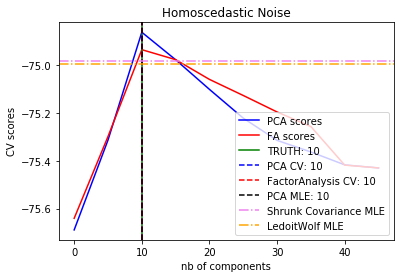

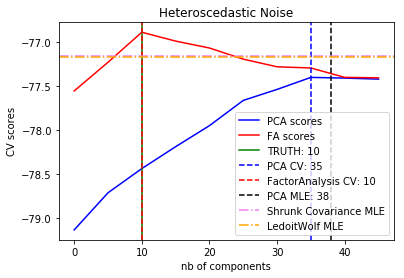

In [48]:
# Authors: Alexandre Gramfort
#          Denis A. Engemann
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.covariance import ShrunkCovariance, LedoitWolf
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

print(__doc__)

# #############################################################################
# Create the data

n_samples, n_features, rank = 1000, 50, 10
sigma = 1.
rng = np.random.RandomState(42)
U, _, _ = linalg.svd(rng.randn(n_features, n_features))
X = np.dot(rng.randn(n_samples, rank), U[:, :rank].T)

# Adding homoscedastic noise
X_homo = X + sigma * rng.randn(n_samples, n_features)

# Adding heteroscedastic noise
sigmas = sigma * rng.rand(n_features) + sigma / 2.
X_hetero = X + rng.randn(n_samples, n_features) * sigmas

# #############################################################################
# Fit the models

n_components = np.arange(0, n_features, 5)  # options for n_components


def compute_scores(X):
    pca = PCA(svd_solver='full')
    fa = FactorAnalysis()

    pca_scores, fa_scores = [], []
    for n in n_components:
        pca.n_components = n
        fa.n_components = n
        pca_scores.append(np.mean(cross_val_score(pca, X, cv=5)))
        fa_scores.append(np.mean(cross_val_score(fa, X, cv=5)))

    return pca_scores, fa_scores


def shrunk_cov_score(X):
    shrinkages = np.logspace(-2, 0, 30)
    cv = GridSearchCV(ShrunkCovariance(), {'shrinkage': shrinkages}, cv=5)
    return np.mean(cross_val_score(cv.fit(X).best_estimator_, X, cv=5))


def lw_score(X):
    return np.mean(cross_val_score(LedoitWolf(), X, cv=5))


for X, title in [(X_homo, 'Homoscedastic Noise'),
                 (X_hetero, 'Heteroscedastic Noise')]:
    pca_scores, fa_scores = compute_scores(X)
    n_components_pca = n_components[np.argmax(pca_scores)]
    n_components_fa = n_components[np.argmax(fa_scores)]

    pca = PCA(svd_solver='full', n_components='mle')
    pca.fit(X)
    n_components_pca_mle = pca.n_components_

    print("best n_components by PCA CV = %d" % n_components_pca)
    print("best n_components by FactorAnalysis CV = %d" % n_components_fa)
    print("best n_components by PCA MLE = %d" % n_components_pca_mle)

    plt.figure()
    plt.plot(n_components, pca_scores, 'b', label='PCA scores')
    plt.plot(n_components, fa_scores, 'r', label='FA scores')
    plt.axvline(rank, color='g', label='TRUTH: %d' % rank, linestyle='-')
    plt.axvline(n_components_pca, color='b',
                label='PCA CV: %d' % n_components_pca, linestyle='--')
    plt.axvline(n_components_fa, color='r',
                label='FactorAnalysis CV: %d' % n_components_fa,
                linestyle='--')
    plt.axvline(n_components_pca_mle, color='k',
                label='PCA MLE: %d' % n_components_pca_mle, linestyle='--')

    # compare with other covariance estimators
    plt.axhline(shrunk_cov_score(X), color='violet',
                label='Shrunk Covariance MLE', linestyle='-.')
    plt.axhline(lw_score(X), color='orange',
                label='LedoitWolf MLE' % n_components_pca_mle, linestyle='-.')

    plt.xlabel('nb of components')
    plt.ylabel('CV scores')
    plt.legend(loc='lower right')
    plt.title(title)

plt.show()